In [1]:
import numpy as np
import rebound as rb
from celmech.secular import SecularSystemSimulation, LaplaceLagrangeSystem
from celmech.poincare import Poincare, PoincareHamiltonian
from celmech.generating_functions import FirstOrderGeneratingFunction
import matplotlib.pyplot as plt
from celmech.nbody_simulation_utilities import align_simulation,set_timestep
from celmech.nbody_simulation_utilities import get_canonical_heliocentric_orbits
from sympy import init_printing
init_printing()

This notebook demonstrates how to use the FirstOrderGeneratingFunction class to calculate approximate mean elements from a set of osculating elements taken from a `rebound` direct $N$-body simulation. This notebooks assumes some basic familiarity with generating functions and Lie transformations in perturbation theory.  

# A simple example

To illustrate `celmech`'s capabilities to implement generating functions and Lie transformations, we'll consider the following simple Hamiltonian that includes the leading-order secular disturbing function and terms from a 3:2 MMR:

$$
H = H_0 + \epsilon H_1\\
H_0 = -\frac{GM_*m_1}{2a_1} -\frac{GM_*m_2}{2a_2} \\
H_1 = -\frac{Gm_1m_2}{a_2}\left(\\
C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\cos(3\lambda_2-2\lambda_1-\varpi_1)+C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\cos(3\lambda_2-2\lambda_1-\varpi_2)\\
+C_{(0,0,0,0,0,0)}^{(0,0,1,0)}e_1^2 + C_{(0,0,0,0,0,0)}^{(0,0,0,1)}e_2^2 + C_{(0,0,1,-1,0,0)}^{(0,0,0,0)}e_1e_2\cos(\varpi_1-\varpi_2)\\
\right)$$

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x121a8a7f0>)

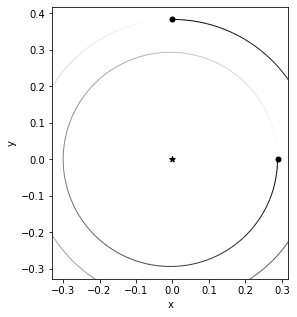

In [2]:
# This function will give us a rebound simluation of pair of planets near a j:j-1 MMR 
# that we'll use to initialize a PoincareHamiltonian object
def get_sim(m1,m2,j,Delta,z1,z2,inc):
    sim = rb.Simulation()
    sim.add(m=1)
    sim.add(m=m1,P=1 ,e = np.abs(z1), pomega = np.angle(z1),Omega=0)
    sim.add(m=m2,P= j*( 1 + Delta)/(j-1),e = np.abs(z2), pomega = np.angle(z2), inc=inc, Omega=np.pi)
    align_simulation(sim)
    sim.move_to_com()
    return sim

Jres = 3
sim = get_sim(3e-5,1e-4,3,0.01, 0.02 , 0.01 * np.exp(0.5j * np.pi), 0.04 )
rb.OrbitPlot(sim)

Now we'll use the `rebound` simulation to initialize our `PoincareHamiltonian`

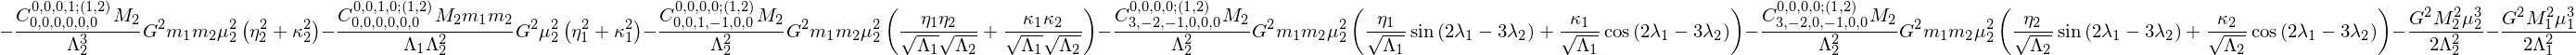

In [3]:
pvars = Poincare.from_Simulation(sim)
pham = PoincareHamiltonian(pvars)

# Add 3:2 MMR terms
pham.add_eccentricity_MMR_terms(Jres,1,1,update=False)

# Add secular terms
pham.add_monomial_term([0 for _ in range(6)],[0,0,1,0],update=False)
pham.add_monomial_term([0 for _ in range(6)],[0,0,0,1],update=False)
pham.add_monomial_term([0,0,1,-1,0,0],[0,0,0,0])

# Hamiltonian
pham.H

This expression is equavalent to the simple Hamiltonian written above, but with orbital elements expressed in terms of canonical variables.

Next, we'll construct a generating function that produces a canonical transformation such that the transformed Hamiltonian is inepended of the mean longitudes to first order in planet masses.

First we'll get a generating function instance:

In [4]:
# This gives us a 'FirstOrderGeneratingFunction' object. 
# The generating function is a function of the same canonical variables
# appearing in the Hamiltonian 'pham' that we made above
chi = FirstOrderGeneratingFunction(pvars)

A generating function is built by adding individual terms to a `FirstOrderGeneratingFunction` object.
Terms are added in such as way that they will eliminate the corresponding terms in a `PoincareHamiltonian` object at first order in planet masses:

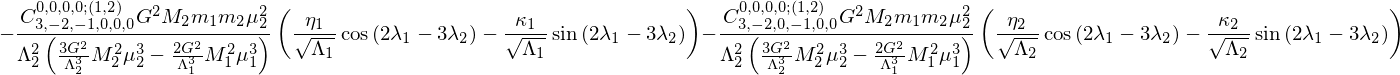

In [5]:
# Adding terms that will cancel the 3:2 MMR terms in a PoincareHamiltonian
chi.add_eccentricity_MMR_terms(Jres,1,1)

# Print The functional form of the generating function, stored as 'H' 
chi.H

This generating function eliminates the mean longitudes from the transformed Hamiltonian to first order in the planet masses.

To see this, write the transformed Hamiltonian as
$$
H' = \exp[{\cal L}_\chi]H =  H_0 + \epsilon H_1 + [H_0,\chi] +{\cal O}(\epsilon^2)
$$
where $H_0$ is the Keplerian piece of the Hamiltonian and $H_1$ captures the rest.

Eliminating dependence on the $\lambda_i$s at first order in $\epsilon$ requires
$$
H_1 + [H_0,\chi] = -\frac{Gm_1m_2}{a_2}\left(
C_{(0,0,0,0,0,0)}^{(0,0,1,0)}e_1^2 + C_{(0,0,0,0,0,0)}^{(0,0,0,1)}e_2^2 + C_{(0,0,1,-1,0,0)}^{(0,0,0,0)}e_1e_2\cos(\varpi_1-\varpi_2)\right)
$$

or, 
$$
n_1\frac{\partial\chi}{\partial\lambda_1} + n_2\frac{\partial\chi}{\partial\lambda_2} =  -\frac{Gm_1m_2}{a_2}\left(C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\cos(3\lambda_2-2\lambda_1-\varpi_1)+C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\cos(3\lambda_2-2\lambda_1-\varpi_2)\right)
$$

This equation is solved by choosing 
$$
\chi = -\frac{Gm_1m_2}{a_2}\left(\frac{C_{(3,-2,-1,0,0,0)}^{(0,0,0,0)}e_1\sin(3\lambda_2-2\lambda_1-\varpi_1)}{3n_2-2n_1}+\frac{C_{(3,-2,0,-1,0,0)}^{(0,0,0,0)}e_2\sin(3\lambda_2-2\lambda_1-\varpi_2)}{3n_2-2n_1}\right)
$$
, which is simply the expression above (written in terms of orbital elements instead of the more cumbersome canonical variables).

# Integration
Now we'll integrate the equations of motion of our Hamiltonian and store both osculating variables as well as transformed variables.

In [6]:
Nout = 200
p1,p2 = sim.particles[1:]
Tsuper = np.abs(2 * np.pi / ((1-Jres) * p1.n + Jres * p2.n))

T = np.linspace(0,16*Tsuper,Nout)

# Arrays for osculating elements
a,e,pomega,l = np.zeros((4,2,Nout))

# Arrays for transformed, mean elements
aTr,eTr,pomegaTr,lTr = np.zeros((4,2,Nout))

In [7]:
for i,t in enumerate(T):
    # Integrate Hamiltonian
    pham.integrate(t)
    
    # Store osculating elements
    for j,p in enumerate(pham.particles[1:]):
        
        a[j,i] = p.a
        e[j,i] = p.e
        pomega[j,i] = p.pomega
        l[j,i] = p.l
    
    # Transform state from osculating to mean
    chi.osculating_to_mean()    
    for j,p in enumerate(pham.particles[1:]):
        
        # Store mean elements
        pTr = chi.particles[j+1]
        aTr[j,i] = pTr.a
        eTr[j,i] = pTr.e
        pomegaTr[j,i] = pTr.pomega
        lTr[j,i] = pTr.l
        
    # Transform state back to osculating for continued integration
    chi.mean_to_osculating()

... and now we'll plot the results:

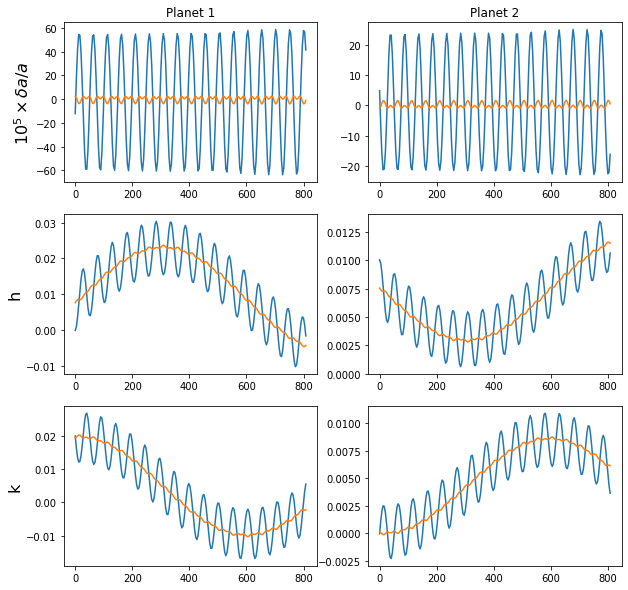

In [8]:
daBya = np.transpose((a.T-np.mean(a,axis=1))/np.mean(a,axis=1))
daByaTr = np.transpose((aTr.T-np.mean(aTr,axis=1))/np.mean(aTr,axis=1))
h,k = e * np.array([np.sin(pomega),np.cos(pomega)])
hTr,kTr = eTr * np.array([np.sin(pomegaTr),np.cos(pomegaTr)])
fig,ax = plt.subplots(3,2,figsize=(10,10))
for i in range(2):
    ax[0,i].plot(T,1e5 * daBya[i])
    ax[0,i].plot(T,1e5 * daByaTr[i])
    
    ax[1,i].plot(T,h[i])
    ax[1,i].plot(T,hTr[i])
    
    ax[2,i].plot(T,k[i])
    ax[2,i].plot(T,kTr[i])
    
ax[0,0].set_title("Planet 1")
ax[0,1].set_title("Planet 2")

for i,lbl in  enumerate([r'$10^5\times \delta a/a$','h','k']):
    ax[i,0].set_ylabel(lbl,fontsize=16)



# N-body case

In [9]:
from celmech.disturbing_function import ResonanceTermsList

In [10]:
# Add more terms to chi to capture effects of other disturbing function terms
for j in range(2*Jres):
    if j==Jres:
        # Add near-resonant terms up to 2nd order in e's and I's
        for k,z in ResonanceTermsList(Jres,1,2,2):
            chi.add_monomial_term(list(k),list(z),update=False)
    else:
        # add other first order in e terms
        chi.add_monomial_term([j,1-j,-1,0,0,0],[0,0,0,0],update=False)
        chi.add_monomial_term([j,1-j,0,-1,0,0],[0,0,0,0],update=False)
#
chi.add_zeroth_order_term()    

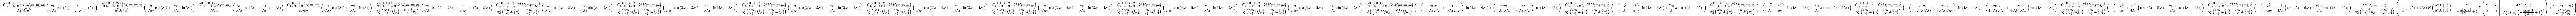

In [11]:
# Print the generating function
chi.H

In [12]:
# Store elements from N-body
a = np.zeros((2,Nout))
e = np.zeros((2,Nout))
inc = np.zeros((2,Nout))
pomega = np.zeros((2,Nout))
Omega = np.zeros((2,Nout))
l = np.zeros((2,Nout))

states = []
for i,t in enumerate(T):
    sim.integrate(t)
    
    # Save snapshots of states in Poincare variables for later
    pvars = Poincare.from_Simulation(sim)
    states.append(chi.state_to_list(pvars))
    
    # Calculate orbits
    orbits = get_canonical_heliocentric_orbits(sim)
    for j,o in enumerate(orbits):
        a[j,i] = o.a
        e[j,i] = o.e
        pomega[j,i] = o.pomega
        l[j,i] = o.l
        inc[j,i] = o.inc
        Omega[j,i] = o.Omega

In [13]:
pvars = chi.state
a_mean = np.zeros((2,Nout))
e_mean = np.zeros((2,Nout))
pomega_mean = np.zeros((2,Nout))
inc_mean = np.zeros((2,Nout))
Omega_mean = np.zeros((2,Nout))
l_mean = np.zeros((2,Nout))

# Loop over stored states to convert osculating elements to mean
for i,state in enumerate(states):
    chi.update_state_from_list(pvars,state)
    chi.osculating_to_mean()
    for j,o in enumerate(pvars.particles[1:]):
        a_mean[j,i] = o.a
        e_mean[j,i] = o.e
        pomega_mean[j,i] = o.pomega
        l_mean[j,i] = o.l
        inc_mean[j,i] = o.inc
        Omega_mean[j,i] = o.Omega

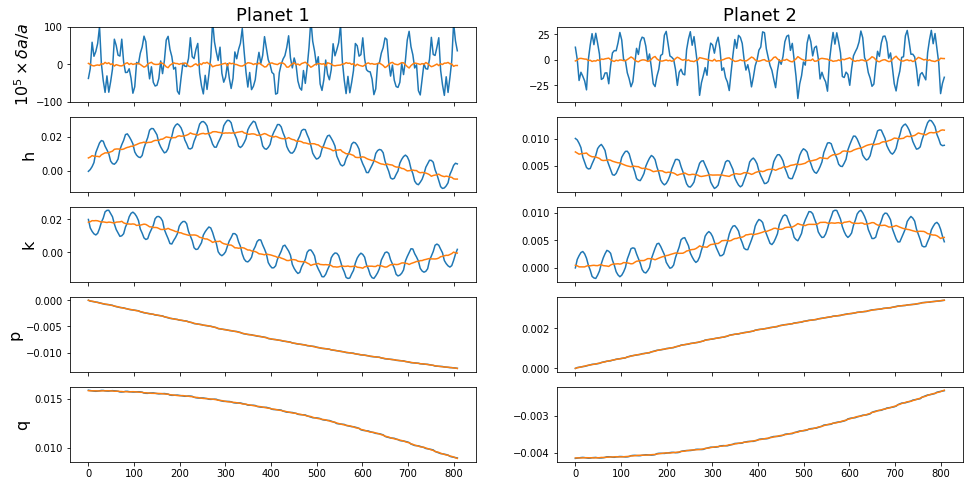

In [14]:
fig,ax = plt.subplots(5,2,sharex=True,figsize=(16,8))
h,k = e * np.sin(pomega),e * np.cos(pomega)
p,q = np.sin(inc/2) * np.sin(Omega),np.sin(inc/2) * np.cos(Omega)


h_mean,k_mean = e_mean * np.sin(pomega_mean),e_mean * np.cos(pomega_mean)
p_mean,q_mean = np.sin(inc_mean/2) * np.sin(Omega_mean),np.sin(inc_mean/2) * np.cos(Omega_mean)

for i in range(2):
    daBya = (a[i]-np.mean(a[i])) / np.mean(a[i])
    da_meanBya_mean = (a_mean[i]-np.mean(a_mean[i])) / np.mean(a_mean[i])
    ax[0,i].plot(T,1e5 * daBya)
    ax[0,i].plot(T,1e5 * da_meanBya_mean)

    ax[1,i].plot(T,h[i])
    ax[1,i].plot(T,h_mean[i])
    
    ax[2,i].plot(T,k[i])
    ax[2,i].plot(T,k_mean[i])


    ax[3,i].plot(T,p[i])
    ax[3,i].plot(T,p_mean[i])
    
    ax[4,i].plot(T,q[i])
    ax[4,i].plot(T,q_mean[i])
    
for i,lbl in  enumerate([r'$10^5 \times \delta a/a$','h','k','p','q']):
    ax[i,0].set_ylabel(lbl,fontsize=16)
    
ax[0,0].set_title("Planet 1",fontsize=18)
ax[0,1].set_title("Planet 2",fontsize=18)
ax[0,0].set_ylim(-100,100);